# Population Estimates: Design the panel-view input for CF

In [1]:
from glob import glob
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')

BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

TIF_FP, INFERENCES_DIR, IMG_FP = load_sources()
tile_bounds_dict_all, tiles_gdf = get_tile_dicts_all_years(oak_fp=OAK_FP, inferences_dir=INFERENCES_DIR)

# * Universe of SJ res parcels assigned to each CBG
sj_parcels_res = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Permits
sj_parcel_permit = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_found.csv'))
sj_permit_noparcel = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_notfound.csv'))
sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])

100%|██████████| 3324/3324 [00:00<00:00, 15779.61it/s]


In [4]:
model_params = {'area_threshold_main': 30, 'area_threshold_small': 20,
                  'flatten_threshold': 0.85, 'main_expansion_type': 'raw_polygons', 
                  'main_polygon_definition': 'OSM', 'negative_buffer': 0.5, 'simplify_tolerance': 0, 
               'limit_2016_inferences': False}

In [5]:
def generate_CF_input(parcel_apn, model_params, sat_imagery, title=True):
    # Collect parcel data
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    # Prepare data
    inferred_buildings_parcel = {'2016': inferred_buildings_2016_parcel,
                                 '2020': inferred_buildings_2020_parcel}
    
    osm_buildings_parcel = {'2016': osm_buildings_parcel,
                            '2020': osm_buildings_parcel}
    print('[INFO] OSM HISTORIC DATA NOT YET INCORPORATED')
    
    # Incorporate OSM data
    parcel_buildings, _ = process_parcel_buildings(
        inferred_buildings_parcel, osm_buildings_parcel, parcel_bounds, model_params)
    
    # Define axis 
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 8))

    # Get individual axis
    ax1, ax2 = axs

    for ax in axs:
        ax.axis('off')

    # Add titles
    if title:
        ax1.set_title('2020')
        ax2.set_title('2016')


    for year, ax in zip(['2020', '2016'], (ax1, ax2)):
        # * NAIP
        # Add buffer to parcel_bounds to get neighborhood/street context
        parcel_bounds_buffered = parcel_bounds.copy()
        parcel_bounds_buffered['geometry'] = parcel_bounds.to_crs('EPSG:26910').buffer(10)

        # Get imagery
        file_name = get_file_name_from_parcel(
            parcel_apn, sat_imagery['sj_parcels_res'], sat_imagery['tiles_gdf'][year])
        img_file, superres_file = find_image_file_and_superrestile(
            sat_imagery['img_fp'][year], sat_imagery['tif_fp'][year], file_name)

        with rasterio.open(superres_file) as src:
            out_image, out_transform = rasterio.mask.mask(
                src, parcel_bounds_buffered.to_crs('EPSG:26910')['geometry'], crop=True, nodata=255)

        # Plot
        rasterio.plot.show(out_image, transform=out_transform, ax=ax, alpha=1)

        ax.axis('off')
        # * Output
        if parcel_buildings[year] is not None:
            output_year = parcel_buildings[year].copy()
            output_year = output_year.loc[output_year['main_building_flag'] == False]
            output_year.geometry = output_year.geometry.exterior
            output_year.to_crs('EPSG:26910').plot(ax=ax, color='red')

        # * Parcel outline
        parcel_bounds.to_crs('EPSG:26910').plot(
            ax=ax, facecolor='none', edgecolor='yellow', linewidth=2)

    plt.show()
    
    return parcel_buildings

[INFO] OSM HISTORIC DATA NOT YET INCORPORATED


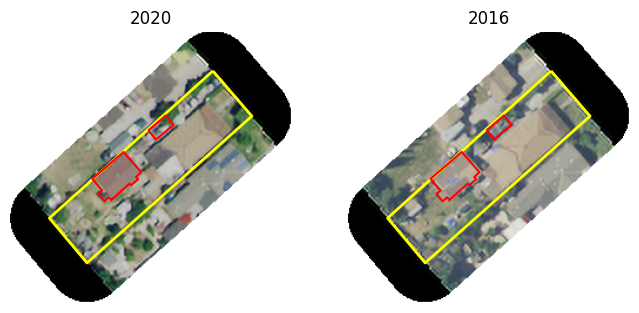

{'2016':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.861000   
 1               False      True          0.891256   
 2               False      True          0.030376   
 
                                             geometry        area  
 0  POLYGON ((-121.84460 37.28880, -121.84460 37.2...  236.295341  
 1  POLYGON ((-121.84473 37.28880, -121.84472 37.2...   79.828713  
 2  POLYGON ((-121.84458 37.28894, -121.84453 37.2...   18.034218  ,
 '2020':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.764688   
 1               False      True          0.886894   
 2               False      True          0.000000   
 
                                             geometry        area  
 0  POLYGON ((-121.84460 37.28887, -121.84460 37.2...  196.258055  
 1  POLYGON ((-121.84473 37.28880, -121.84472 37.2...   79.828713  
 2  POLYGON ((-121.84458 37.28894, -121.84453 37.2...   18.034218  }

In [14]:
# 23041017, 23510054
generate_CF_input(parcel_apn='49722035', 
                  model_params=model_params, 
                  sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res,
                 'tiles_gdf': tiles_gdf})

# Tile centroids

In [6]:
with open(os.path.join(
    '/oak/stanford/groups/deho/building_compliance/CloudFactory/images/img_metadata.p'), "rb") as output_file:
        results = pickle.load(output_file)

In [37]:
parcels = pd.DataFrame()
for apn, val in results.items():
    parcel_dict = {'APN': [apn], 'geometry': [val['parcel_bounds']]}
    parcels = pd.concat([parcels, pd.DataFrame.from_dict(parcel_dict)])

In [41]:
parcels = gpd.GeoDataFrame(parcels, geometry='geometry', crs='EPSG:26910')
parcels = parcels.to_crs('EPSG:4326')

In [44]:
parcels.head()

,APN,geometry
0,38101084,"POLYGON ((-121.98748 37.31164, -121.98756 37.3..."
0,70625017,"POLYGON ((-121.76770 37.23011, -121.76791 37.2..."
0,59905088,"POLYGON ((-121.83847 37.38204, -121.83862 37.3..."
0,69527011,"POLYGON ((-121.84039 37.23231, -121.84074 37.2..."
0,70845081,"POLYGON ((-121.76476 37.22153, -121.76477 37.2..."


In [23]:
# List of images
images = glob('/oak/stanford/groups/deho/building_compliance/CloudFactory/images/round1/*')
images = [i.split(os.path.sep)[-1].replace('.png', '') for i in images]
print('Num. images: {}'.format(len(images)))

Num. images: 5541


In [32]:
missing = [i for i in images if i not in parcels['APN'].unique()]

In [51]:
print(missing)

['49433023', '67026051', '49432015', '49436014', '67037035', '67026052', '47225064', '47227035', '47744011', '47748006', '28425019', '48643036', '49437024', '49435023', '48635021', '48641001', '47228004', '49433041', '67027056']


In [45]:
# Load parcel bounds
missing_parcels = sj_parcels_res.loc[sj_parcels_res['APN'].isin(missing)]
parcels = pd.concat([parcels, missing_parcels[['APN', 'geometry']]])

In [46]:
parcels['centroid'] = parcels.geometry.centroid

In [48]:
parcels = parcels.loc[parcels['APN'].isin(images)]

In [54]:
parcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5541 entries, 0 to 151852
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   APN       5541 non-null   object  
 1   geometry  5541 non-null   geometry
 2   centroid  5541 non-null   geometry
dtypes: geometry(2), object(1)
memory usage: 173.2+ KB


In [56]:
parcels[['APN', 'centroid']].to_csv(
    '/oak/stanford/groups/deho/building_compliance/CloudFactory/images/centroids.csv', index=False)